# Part 0. Description

This script is a part of our work on the intepretation of machine learning models in neuroimaging. See more [details](https://github.com/cocoanlab/interpret_ml_neuroimaging)

In this example, we will classify **Heat pain trial** and **Rejection trial** fMRI data using Convolutional Neural Network (CNN) and we will use Layer-wise Relevance Propagation (LRP) [(Bach et al., 2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) to explain the predictions of the model. 

The data consists of **59 subjects**. Each subject has **8 heat trials** and **8 rejection trials**.

We will do Leave-One-Subject-Out cross-validation which means 59-fold cross-validation will be executed. In order to track which subject is held-out as a test set, we save the model number matched with the subject number. For example, if `sub_01` is the test set (first fold cross-validation), then model name is `model_01`

Since we have 59 folds's results and models, it will be difficult to manage all of them. So we will use data matrix so that we can easily handle the results and models.

When initialized, the data Frame contains: `'data_path'`(**where the data is saved**), `'type'`(**which type of stimulus is used on this data**), `'type_onehot'`(**One-Hot encoding of type**), `'subject'`(**subject number**)

After the CNN model training, the following columns will be added:

`'predicted_type_onehot'`(**predicted type by trained CNN model**), `'model_name'`(**which model is used for prediction**), `'model_weight_path'`(**where the model weight is saved**), `'model_acc'`(**accuracy of model for test data sets**), `'model_loss'`(**loss of model for test data sets**)


这个脚本是我们在神经成像中解释机器学习模型工作的一部分，更多信息详见(https://github.com/cocoanlab/interpret_ml_neuroimaging)

在这个例子中,我们将分类* ”躯体疼痛任务（其中被试经历了痛苦的高温（heat）或不痛的温暖（warm））” *和* ”社交排斥（rejection）任务（其中被试查看了其前伴侣或朋友的照片）”* fMRI数据使用卷积神经网络(CNN),我们将使用Layer-wise相关性传播(LRP[(Bach et al., 2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140)来解释模型的预测。

数据由**59名受试者**组成。每个受试者有**8次躯体疼痛任务**和**8次社交排斥**。

我们进行留一法交叉验证，即执行59次的交叉验证。为了跟踪作为测试集保留的受试者，我们保存与受试者编号匹配的模型编号。例如，如果' sub_01 '是测试集(首先进行交叉验证)，那么对应模型名是' model_01 '

因为我们有59个训练的结果和模型，所以很难进行管理。因此，我们将使用数据矩阵，以便我们可以轻松地处理结果和模型。

初始化时，数据结构包括: `'data_path'`(**数据保存在哪里**), `'type'`(**在这个数据上使用了哪些刺激**), `'type_onehot'`(**One-Hot encoding of type**), `'subject'`(**subject number**)

In [1]:
#下面是该脚本的输出数据矩阵示例。在训练CNN模型之前不要执行这个单元。下面是该脚本的输出数据矩阵示例。在训练CNN模型之前不要执行这个单元。

#The following is an example of the output data matrix of this script. Do not execute this cell before you train CNN models.
#  df.head(n=20)

# Part 1. Initializing Data Frame
# 初始化数据结构
# Part 1 中对初始的数据结构进行了定义，最后得到的效果详见df.head(n=20)
# 补充说明，这里作者用的是pandas包里的DataFrame创建数据模板

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image
import nipype.interfaces.io as nio
import os

import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from keras.models import load_model


#numpy：专门用于矩阵计算的库
#pandas：大型数据集分析库
#matplotlib：绘图数据库
#nilearn：神经影像的机器学习处理数据库
#os：操作系统的功能接口函数
#klearn：python第三方机器学习库
#matplotlib inline


Bad key savefig.frameon in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filen

Setting base directory(`datapath`) for searching files and saving results(`result_path`, `dataframe_filename`)

设置程序基本目录用于搜索和保存结果

In [3]:

    datapath = 'D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/data/derivatives/trial_images'
    result_path = 'D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp'
    dataframe_filename = 'cnn_lrp_dataframe.csv'

以上是文件保存和查找的基本地址

This is a template of files that you want to find in the base directory(`datapath`).

In [4]:
heat_search_template = 'sub_*/heat*.nii'
rejection_search_template = 'sub_*/rejection*.nii'

上面一行指的是获取目录中的文件列表，使用的是“nipype.interfaces.io.DataGrabber()”
具体参考地址为https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html

We will use `nipype.interfaces.io.DataGrabber()` to get the list of the files in the  directory.

If you want to know the details of `DataGrabber()`, see this [reference](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html)

In [5]:
datasource = nio.DataGrabber()
datasource.inputs.base_directory = datapath
datasource.inputs.template = heat_search_template
datasource.inputs.sort_filelist = True
heat_imgs = datasource.run().outputs.get()['outfiles']

datasource.inputs.template = rejection_search_template
rejection_imgs = datasource.run().outputs.get()['outfiles']

all_imgs = np.concatenate((np.array(heat_imgs, dtype=object), np.array(rejection_imgs, dtype=object)))

上面的代码是将在我们电脑中设置的绝对地址，改为程序中运行的相对地址

Change data path from absolute path to relative path


下面的内容定义了一个函数，从全文来看,这个函数是表征绝对路径和相对路径关系的。

In [6]:
def abs_path_to_rel(abs_path, break_point):
    split_path_list = []

    while True:
        abs_path, split_path = os.path.split(abs_path)
        split_path_list.append(split_path)

        if break_point in split_path:
            break

    for i in range(len(split_path_list)):
        if i == 0:
            rel_path = os.path.join('..', split_path_list[-(i+1)])
        else:
            rel_path = os.path.join(rel_path, split_path_list[-(i+1)])

    return rel_path

In [7]:
rel_all_imgs = []
for i in range(len(all_imgs)):
    rel_img_path = abs_path_to_rel(all_imgs[i], 'data')
    rel_all_imgs.append(rel_img_path)

初始化数据结构 df ，包含  `data_path`, `type`, `type_onehot`, `subject`
（以下内容）

Initializing data frame(`df`) with columns `data_path`, `type`, `type_onehot`, `subject`.

In [8]:
df = pd.DataFrame(rel_all_imgs, columns=['data_path'])
df['type']= None
df['type_onehot'] = None
df['subject']= None

以下是对pandas的基本操作介绍，后面的代码,df.loc是多维选取（区域选取）的意思，df[]是以行或者列为单位进行选取

This is basic usage of `Pandas`. If you are not familiar with `Pandas`, see 

[*Getting started*](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html)

[`pandas.Series.str.find`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.find.html) 

[`pandas.Series.str.extract`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html)

In [9]:
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type'] = 'heat'
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type'] = 'reject'
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type_onehot'] = 1
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type_onehot'] = 0
df['subject'] = df['data_path'].str.extract(r'(sub_\d\d)')

df = df.replace(to_replace='None', value=np.nan).dropna()
df.reset_index(inplace=True)

使用df.head(n=n)可以看到数据结构的前n行
因为现在还没训练模型，也没执行LRP，所以数据结构中只包含初始输入的数据

You can see the first **n** rows of data frame using `df.head(n=n)`

Since we have not trained the CNN model nor performed LRP, the data frame contains only details about our input data.  As we go further through the script, more columns will be added.

然后df.head，即为查看数据，df.head(n=20)，查看20行的数据、

In [10]:
df.head(n=20)

,index,data_path,type,type_onehot,subject
0,0,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
1,1,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
2,2,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
3,3,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
4,4,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
5,5,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
6,6,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
7,7,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01
8,8,..\data\derivatives\trial_images\sub_02\heat_t...,heat,1,sub_02
9,9,..\data\derivatives\trial_images\sub_02\heat_t...,heat,1,sub_02


# Part 2. Loading Data Function

The following code defines a function that we will use later to load data.

# 接下来的代码定义一个函数，用于载入数据（实际上到时候改代码不需要动这个）

# 使用Nilearn包从NlfTI文件中读取数据
# 这里只说一点，输入数据应该是4个维度的，X,Y,Z,N X,Y,Z为我们的扫描部位，以体素为单位，还有一个是扫描时间点，最终组成一个时间序列

# https://zhuanlan.zhihu.com/p/288051677

In [11]:
def load_dat(df, train_index, test_index, transpose_index=[3,2,1,0], do_masking=False, mask_path=None, do_masker = False):

    #Extract data path and labels from data matrix
    tr_path_X, te_path_X = df['data_path'][train_index].to_numpy(), df['data_path'][test_index].to_numpy()
    train_y, test_y = df['type_onehot'][train_index].to_numpy(), df['type_onehot'][test_index].to_numpy()
    
    from nilearn import image    
    
    if not do_masking:
        train_X = image.load_img(tr_path_X).get_fdata()
        test_X = image.load_img(te_path_X).get_fdata()
    
    elif do_masking:
        if do_masking and mask_path==None:
            raise ValueError('For masking, you need to set mask_path')
            
        from nilearn.masking import apply_mask, unmask
        from nilearn.image import resample_to_img
        from nilearn.input_data import NiftiMasker

        mask_img = image.load_img(mask_path)
        
        tr_X = image.load_img(tr_path_X)
        te_X = image.load_img(te_path_X)
        
        temp_img = image.load_img(tr_path_X[0])
        mask_img = resample_to_img(mask_img, temp_img, interpolation='nearest')


        #Extract bool mask from epi mask image
        if do_masker:
            masker = NiftiMasker(mask_strategy='epi')
            fitted_masker = masker.fit(mask_img)
            mask_img = fitted_masker.mask_img_
        
        tr_X = unmask(apply_mask(tr_X ,mask_img), mask_img)
        te_X = unmask(apply_mask(te_X ,mask_img), mask_img)
        
        train_X = tr_X.get_fdata()
        test_X = te_X.get_fdata()
    
    #Transpose matrix in order to match CNN model's input layer
    #Keras(or Tensorflow) is using (Number of data, height, width, channel) data shape for 2D image(https://keras.io/layers/convolutional/) and channel will be 'cutting axis'.
    #For brain images, nibabel using (x[left/Right;], y[posterior/Anterior], z[inferior/Superior], Number of data) data shape(https://nipy.org/nibabel/coordinate_systems.html).
    #You need to decide which axis will be cutting axis(like channel).
    #In this example, we choose 'x' axis as a cutting axis.
    #[x, y, z, N] => [N, z, y, x], ([79, 95, 68, N] => [N, 68, 95, 79])

    #实际上这里也指出了，大脑图像的编码方式是[x,y,z,N] x,y,z表明了三维图像坐标，N表明了图像的数量，即时间序列

    train_X = train_X.transpose(transpose_index)
    test_X = test_X.transpose(transpose_index)
    fmri_shape = train_X.shape[1:]
    
    return train_X, train_y, test_X, test_y, fmri_shape

# Part 3. CNN Model

# 建立卷积神经网络模型（Kreas）

In [12]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

We are using `Keras` for making CNN models

You can see details of `Keras` usage in [here](https://keras.io/)

下面的代码就是导入Kreas包

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam

make CNN model with **6 layers**, Flatten() is inserted between CNN and **fully connected layers**.

该代码定义了四个卷积层和两个全连接层，然后是softmax输出层。 还可以使用Adam优化器定义损失函数以进行模型训练

In [14]:
#从下面开始，建立CNN

def make_custom_model_cnn_2D(fmri_shape):

    #导入sequentail，然后即可引入CNN的各种层数
    #Sequentail函数用法参考以下链接：https://blog.csdn.net/yunfeather/article/details/106461462
    model = Sequential()

    #下面这行开始就是建立相关模型
    #CNN模型的参考链接：https://blog.csdn.net/qq_30527579/article/details/106782019
    #https://blog.csdn.net/jialibang/article/details/108000356
    #https://blog.csdn.net/zuolixiangfisher/article/details/80528989
    #https://blog.csdn.net/qq_28949847/article/details/107045867

    #卷积层
    #第一层keras.layers.Conv2D(filters, kernel_size, strides=(1, 1),
    #padding='valid', data_format=None,
    #dilation_rate=(1, 1), activation=None,
    # use_bias=True, kernel_initializer='glorot_uniform',
    #bias_initializer='zeros', kernel_regularizer=None,
    # bias_regularizer=None, activity_regularizer=None,
    #kernel_constraint=None,)

    #关于上述参数的说明：
    #filters： 卷积核的数量，决定输出数据的最后一维(channels)的大小。
    #kernel_size：卷积核的大小（形状），决定输出数据 height, width 维度的大小。
    #strides： 卷积操作时步长，可以是一个整数代表height, width方向的步长相同，也可以是（x, y）表示height方向的步长为x,width方向的步长为y。
    #padding：等于’valid’时卷积核在 输入数据形状（height, width）最大范围内 进行移动，等于’same’时如果（height, width）没有恰好完全符合设定的kernel_size和strides，超出的部分将会填充0.
    #activation： 激活函数
    #use_bias： 是否使用偏置量
    #kernel_initializer： 卷积核的初始化方式
    #bias_initializer： 偏置量的初始化方式

    #所以第一个卷积层具体信息如下
    #卷积核8个，卷积核大小3x3,卷积核初始化方式 he_normal,下面一行是he_normal的参考文献
    #说明:Delving Deep into Rectifiers:Surpassing Human-Level Performance on ImageNet Classification
    #padding操作，填充0进入图像边缘中，避免出现卷积核难以提取全部信息
    #输入的数据结构就是fmri的结构

    model.add(Conv2D(8, (3,3), kernel_initializer='he_normal', padding='same', input_shape=fmri_shape))

    #CNN中使用的激活函数 rulu 函数
    #优点 1.解决了梯度消失的问题 (在正区间)
    #    2.计算速度非常快，只需要判断输入是否大于0
    #    3.收敛速度远快于sigmoid和tanh
    #    4.Relu会使一部分神经元的输出为0，这样就造成了网络的稀疏性，并且减少了参数的相互依存关系，缓解了过拟合问题的发生
    model.add(Activation('relu'))

    #最大池化层
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2),
    #strides=None, padding='valid',
    #data_format=None, **kwargs)

    #关于上述参数的说明：
    #pool_size = (2,2),池化核的尺寸，默认是2×2
    #strides = None，移动步长的意思 ，默认是池化核尺寸，即2，
    #padding = ‘valid’,是否填充，，默认是不填充
    #data_format = ‘channels_last’,输入数据的格式为(batch_size, pooled_rows, pooled_cols, channels)）
    #输入数据格式为（图片数（批量大小），池化层行数，池化层列数和通道数（比如RGB就是三通道）)

    #池化层物理意义
    #对输入的特征图进行压缩，一方面使特征图变小，简化网络计算复杂度；一方面进行特征压缩，提取主要特征
    #参考资料：https://blog.csdn.net/yjl9122/article/details/70198357

    #所以第一个池化层的信息就是，池化核尺寸2X2,提取2X2的区域中的最大值
    model.add(MaxPooling2D(pool_size=(2,2)))
    #以上三行，卷积神经网络第一层搭建完成，由卷积层，设置激活函数，和池化层三行代码组成


    #第二个卷积层
    #卷积核16个，卷积核大小3x3,卷积核初始化方式 he_normal,
    #激活函数 rulu 函数
    #最大池化层，池化核尺寸2X2,提取2X2的区域中的最大值
    model.add(Conv2D(16, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    #第三个卷积层
    #卷积核32个，卷积核大小3x3,卷积核初始化方式 he_normal,
    #激活函数 rulu 函数
    #最大池化层，池化核尺寸2X2,提取2X2的区域中的最大值
    model.add(Conv2D(32, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #第四个卷积层
    #卷积核64个，卷积核大小3x3,卷积核初始化方式 he_normal,
    #激活函数 rulu 函数
    #最大池化层，池化核尺寸2X2,提取2X2的区域中的最大值
    #说明：随着层数的增多，卷积核的数量也变多，我理解的是低级特征少数卷积核即可提取，随着特征的维度变高，
    #需要更多的卷积核才能寻找高维特征之间的关系
    model.add(Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
    #参考文献：https://blog.csdn.net/qq_28949847/article/details/109069021
    model.add(Flatten())

    #keras.layers.Dense(units, activation=None,
    #use_bias=True, kernel_initializer='glorot_uniform',
    #bias_initializer='zeros', kernel_regularizer=None,
    #bias_regularizer=None, activity_regularizer=None,
    #kernel_constraint=None, bias_constraint=None)

    #units ：代表该层的输出维度或神经元个数, units解释为神经元个数为了方便计算参数量，解释为输出维度为了方便计算维度
    #activation=None：激活函数.但是默认 liner (详见API的activation)
    #use_bias=True：布尔值，该层是否使用偏置向量b
    #kernel_initializer：初始化w权重 (详见API的initializers)
    #bias_initializer：初始化b权重 (详见API的initializers)
    #kernel_regularizer：施加在权重w上的正则项 (详见API的regularizer)
    #bias_regularizer：施加在偏置向量b上的正则项 (详见API的regularizer)
    #activity_regularizer：施加在输出上的正则项 (详见API的regularizer)
    #kernel_constraint：施加在权重w上的约束项 (详见API的constraints)
    #bias_constraint：施加在偏置b上的约束项 (详见API的constraints)

    #输出维度为128维度，约束项为he_normal(He正态分布初始化)
    #he_normal参考文献：https://blog.csdn.net/bestxyj/article/details/98850071
    #激活函数为relu函数
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(Activation('relu'))

    #输出维度为2维度，约束项为he_normal(He正态分布初始化)
    model.add(Dense(2, kernel_initializer='he_normal'))
    #激活函数为线性函数函数
    model.add(Activation('linear'))


    #最终输出的激活函数为softmax函数，即归一化指数函数
    #softmax函数是sigmoid二分类函数在多分类上的推广
    #参考资料：https://blog.csdn.net/lz_peter/article/details/84574716
    model.add(Activation('softmax'))

    #优化算法：Adam算法https://blog.csdn.net/leadai/article/details/79178787?ops_request_misc=&request_id=&biz_id=102&utm_term=Adam(lr=0.001,%20beta_1=0.9,%20bet&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-79178787.pc_search_ecpm_flag&spm=1018.2226.3001.4187
    #胡磊：通过查阅其他资料发现，作者这里设置的参数其实不是自己调出来的，就是主流的参数设置方法
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


    #model.compile()方法  用于在配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准
    #损失函数 categorical_crossentropy 类别交叉熵损失函数
    #损失函数参考资料：https://blog.csdn.net/qq_40661327/article/details/107034575

    #优化器：Adam算法

    #准确率评判标准，正确率（准确率，正确率，查全率，查准率是啥ppt去）

    #总体参考资料：https://blog.csdn.net/yunfeather/article/details/106461754
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    #建模完成
    return model

Functions for creating & training model
# 创建训练模型的函数

In [15]:
   #这里有个小说明，如果没有GPU，就删去第二行的# ，提高计算效率

def train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=200, patience=40):
    # Optional: if you do not have enough GPUs, use the following line  
    #with tf.device('/cpu:0'):

    #下面几行的代码，我个人理解就是在设置临时变量
    tr_data = {}
    tr_data['X_data'] = train_X
    tr_data['y_data'] = train_y

    te_data = {}
    te_data['X_data'] = test_X
    te_data['y_data'] = test_y


    #to_categorical就是将类别标签向量转换为二进制（只有0和1）的矩阵类型表示。每一个标签用矩阵的对应的行向量来表示。
    #Eg:例如类别的标签为0、1、2、3、4，将数据分为这5类，则经过to_categorical函数作用后。
    # 0—1 0 0 0 0
    # 1—0 1 0 0 0
    # 2—0 0 1 0 0
    # 3—0 0 0 1 0
    # 4—0 0 0 0 1
    tr_data['y_data'] = keras.utils.to_categorical(tr_data['y_data'], 2)
    te_data['y_data'] = keras.utils.to_categorical(te_data['y_data'], 2)
    #上面几行的代码，我个人理解就是在处理标签变量



    #训练样本计数
    training_sample_count = tr_data['X_data'].shape[0]

    #初始化并且编译模型
    # Initialize and compile the model
    model = make_custom_model_cnn_2D(fmri_shape)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy"])


    #EarlyStopping，早停法，一种防止出现过拟合的技巧
    #参考资料：https://blog.csdn.net/df19900725/article/details/82973049
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]

    
    history = model.fit(tr_data['X_data'],
                        tr_data['y_data'],
                        batch_size=mini_batch_size,
                        epochs=epochs,
                        validation_data=(te_data['X_data'], te_data['y_data']),
                        callbacks=callbacks,
                        shuffle=True,
                        verbose=1)

    #model.evaluate函数，输入数据和标签，输出损失和精确度
    score = model.evaluate(te_data['X_data'], 
                           te_data['y_data'], 
                           verbose=0)
    
    print("\nTest Accuracy is {}\n".format(score[1]))
    
    return model,score

# Part 4. Model Training example
# 模型训练样例

This is a 'test' training example for checking whether those codes are working.

sub_01 will be the test dataset,
the rest will be the training dataset

# 训练样例，检测模型能否正常工作
# sub_01是测试集，其他都是训练集

In [16]:
#LeaveOneGroupOut came from 'from sklearn.model_selection import LeaveOneGroupOut'
#这个地方表明 logo 这个变量 等于 留一法
logo = LeaveOneGroupOut()

In [17]:
#sub_01 will be test set 
train_index, test_index = logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject']=='sub_01')

train_index = train_index[1]
test_index = test_index[1]

#Load numpy array data from data path
#从数据路径加载numpy数组数据
#最终给出了train_X和test_X的数值大小
#我理解的是，训练集有928个样本，验证集有16个样本，不过为什么是这样还需要研究


train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
print("train_X shape is {}".format(train_X.shape))
print("test_X shape is {}".format(test_X.shape))

train_X shape is (928, 68, 95, 79)
test_X shape is (16, 68, 95, 79)


When you are using GPU(Graphics Processing Unit) for training, tensorflow automatically use all GPU memory even if the model, we want to train, is not that much huge.

In order to use GPU memory just as much we need, we can use `gpu_options.allow_growth = True` option from tensorflow

# tf.ConfigProto()主要的作用是配置tf.Session的运算方式，比如gpu运算或者cpu运算

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# 下面一行：调用模型训练函数

In [19]:
# Create & train model
model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=5, patience=20)

Train on 928 samples, validate on 16 samples
Epoch 1/5
928/928 [==============================] - 22s 23ms/step - loss: 1.8818 - acc: 0.4914 - val_loss: 0.8255 - val_acc: 0.4375
Epoch 2/5
928/928 [==============================] - 28s 30ms/step - loss: 0.7445 - acc: 0.5248 - val_loss: 0.6762 - val_acc: 0.6250 - ETA: 12s - loss: 0.7311 - acc: 0.5286

# Part 5. Leave-One-Subject-Out Cross-validation 

# Part 5 留一法交叉验证

# 个人理解：留一法，确定最优模型（或者说最优超参数），超参确定后，把所有数据用于训练网络，最后再放到新的验证集中验证
If the codes are working, we can perform 59-fold cross-validation.

Keep in mind that **it will take hours**, depending on your computer performance.

In [20]:
logo = LeaveOneGroupOut()

#Making new colums to save results
#在数据结构中添加新的列用来保存结果

df['predicted_type_onehot'] = None
df['model_name'] = None
df['model_weight_path'] = None
df['model_acc'] = None
df['model_loss'] = None

In [21]:
#下面三行代码还是调用GPU进行运算

#Warning! It will take hours
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#This time, it will be executed for all cross-validation sets
for i, (train_index, test_index) in enumerate(logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject'])):

    #导入数据
    #Load numpy array data from data path
    train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
    print("Cross validation {}".format(i+1))

    #创建且训练模型
    #Create & train model
    model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=5, patience=20)

    #创建模型名称用以保存
    #Making model name for saving
    model_name = 'model_{:02d}'.format(i+1)
    model_path = os.path.join(result_path, model_name)
    model_path = abs_path_to_rel(model_path, 'results')

    #创建文件夹保存训练好的模型
    #Create folders for saving model
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    # We are going to save 'model without weight' and 'model's weight'
    # 'model without weight' is graph of cnn model without weight and will be saved as '.json' file. 
    # Since we used one cnn model for all cross-validation, we only need to save one model's graph.
    # 'model's weight' will be saved as '.h5' file and need to be saved for all trained model.

    #上面4行的英文翻译
    #保存的是“无权重模型“和”有权重模型“，无权重模型保存为.json文件形式
    #有权重模型保存为.h5文件形式

    #保存模型拓扑图，不带模型权重
    #Saving Model's graph without trained weight
    if i == 0:
        model_file_path = os.path.join(result_path, ('model_without_weight.json'))
        model_json = model.to_json()
        with open(model_file_path, "w") as _file : 
            _file.write(model_json)

    #保存模型拓扑图，带上模型权重
    #Saving Model's trained weight
    model_weight_file_path = os.path.join(model_path, (model_name + '_weight.h5'))
    model.save_weights(model_weight_file_path)

    #输出模型名（第几个模型)
    print("{} is saved".format(model_name))

    #向数据结构中保存模型名称
    #Saving results to the data frame
    df['model_name'][test_index] = model_name
    df['model_weight_path'][test_index] = model_weight_file_path
    df['model_acc'][test_index] = score[1]
    df['model_loss'][test_index] = score[0]


    #使用训练好的CNN模型，对测试集进行测试
    #Getting predictions for test data using trained CNN model
    test_images = list(zip(test_X, test_y))
    for p, (x, y) in enumerate(test_images):
        # Add batch axis.
        x = x[None, :, :, :]

        #Prediction
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        #保存预测结果于数据结构中
        #Saving prediction results to the data frame
        df['predicted_type_onehot'][test_index[p]] = y_hat

    #把训练结果保存为csv文件，实际上最后是个excel文件
    #Saving data frame as csv file format
    df_csv_path = os.path.join(result_path, dataframe_filename)
    df.to_csv(df_csv_path)

Cross validation 1
Train on 928 samples, validate on 16 samples
Epoch 1/5
928/928 [==============================] - 14s 15ms/step - loss: 2.4742 - acc: 0.5032 - val_loss: 0.6599 - val_acc: 0.6875
Epoch 2/5
928/928 [==============================] - 14s 15ms/step - loss: 0.7677 - acc: 0.5269 - val_loss: 0.6265 - val_acc: 0.6875

# Part 6. Total Accuracy
# Part 6. 总体准确率(少量语句未注释，记得填坑）
At each cross-validation fold, the predictive accuracy is calculated.

You can also get mean accuracy value of all cross-validation folds.

And after cross-validation, you can load the results from the data frame file, so you don't have to train again.

#在交叉验证后，就可以直接在数据结构里加载结果，不需要再进行训练了

In [22]:
#Loading the data frame.
#这个就是导入我们交叉验证后的结果，似乎这边是对所有的模型赋权重，最后得到一个加权的新模型
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

,Unnamed: 0,index,data_path,type,type_onehot,subject,predicted_type_onehot,model_name,model_weight_path,model_acc,model_loss
0,0,0,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
1,1,1,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
2,2,2,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
3,3,3,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
4,4,4,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168


In [23]:
#Extract models names
#提取模型名称，提取总体正确率
model_names = df['model_name'].unique()
total_acc = []

#Extract Accuracy at each models
for model_name in model_names:
    total_acc.append(df[df['model_name'] == model_name]['model_acc'].unique()[0])
    
total_acc = np.array(total_acc)

(array([ 1.,  0.,  4.,  0.,  1.,  0.,  3.,  0., 11.,  0.,  1.,  0.,  7.,
         0., 12.,  0.,  7.,  0.,  8.,  4.]),
 array([0.375  , 0.40625, 0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 ,
        0.59375, 0.625  , 0.65625, 0.6875 , 0.71875, 0.75   , 0.78125,
        0.8125 , 0.84375, 0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 <BarContainer object of 20 artists>)

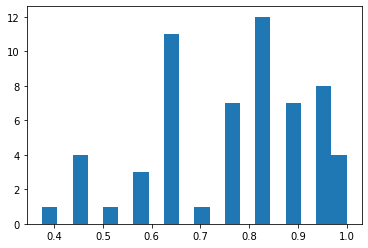

In [24]:
plt.hist(total_acc, bins=20)

In [25]:
print("Total Accuracy mean {}".format(total_acc.mean()))
print("Total Accuracy std {}".format(total_acc.std()))

Total Accuracy mean 0.7542372881355932
Total Accuracy std 0.16268096458010564


# Part 7. Layer-wise Relevance Propagation

# Part 7. 分层相关传播

In [26]:
#Loading the data frame, if you need.
#载入数据结构
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

,Unnamed: 0,index,data_path,type,type_onehot,subject,predicted_type_onehot,model_name,model_weight_path,model_acc,model_loss
0,0,0,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
1,1,1,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
2,2,2,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
3,3,3,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168
4,4,4,..\data\derivatives\trial_images\sub_01\heat_t...,heat,1,sub_01,1,model_01,..\results\cnn_lrp\model_01\model_01_weight.h5,0.9375,0.360168


LRP needs the input data to calculate Relevance scores.

LRP模型需要输入数据来计算相关得分

In [27]:
logo = LeaveOneGroupOut()

#sub_01 will be test set 
train_index, test_index = logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject']=='sub_01')

train_index = train_index[1]
test_index = test_index[1]

#Load numpy array data from data path
train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
print("train_X shape is {}".format(train_X.shape))
print("test_X shape is {}".format(test_X.shape))

train_X shape is (928, 68, 95, 79)
test_X shape is (16, 68, 95, 79)


Since we already checked cross-validation results, for LRP, we are going to train a model using all data.

# 对于LRP，我们将使用所有数据来训练模型。

In [28]:
#np.concatenate((a,b,c,… ))能够一次完成多个数组的拼接。
#参考资料：https://blog.csdn.net/weixin_43251493/article/details/105920315

train_all_index = np.concatenate((test_index, train_index))
train_all_X = np.concatenate((test_X, train_X), axis=0)
train_all_y = np.concatenate((test_y,train_y))



In [29]:
# Create & train model
# 这里好像是在设置模型训练函数
model_for_lrp, score = train_model(fmri_shape, train_all_X, train_all_y, test_X, test_y, mini_batch_size=128, epochs=20, patience=20)

Train on 944 samples, validate on 16 samples
Epoch 1/20
944/944 [==============================] - 18s 19ms/step - loss: 2.0271 - acc: 0.5064 - val_loss: 0.9623 - val_acc: 0.5000
Epoch 2/20
944/944 [==============================] - 12s 13ms/step - loss: 0.7517 - acc: 0.5413 - val_loss: 0.7382 - val_acc: 0.5000

For LRP, you can select ouput node for calculating relevance score. `'None'` means **max_activation** node and you can use specific node number like `0` or `1`
#在LRP（分层相关传播）训练中，我们将使用受试者平均图像作为LRP的输入图像（**每个受试者将有一个平均热痛试验图像和一个平均社交排斥试验图像**）

In [30]:
#investigate ：调包

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
import nibabel as nib

selection_index_LRP=[0,1,None]

# 以下是LRP模型训练过程
# LRP模型参考资料：https://zhuanlan.zhihu.com/p/261979162

For this example, We are going to use subject-wise averaged images as input images(**each subject will have one averaged heat trial image and one averaged rejection trial image**) for LRP

LRP start!

In [31]:
subject_list = df['subject'].unique()
type_list = df['type'].unique()
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_for_lrp)

# https://zhuanlan.zhihu.com/p/261979162

In [32]:
for selection_index in selection_index_LRP:
    # Configure analysis methods and properties
    # 配置训练方法和属性
    if selection_index == None:
        method = ("lrp.epsilon",    {"epsilon": 1,"neuron_selection_mode":"max_activation"},    ivis.heatmap,    "LRP-Epsilon")
    else:
        method = ("lrp.epsilon",    {"epsilon": 1, "neuron_selection_mode" : "index"},    ivis.heatmap,     "LRP-Epsilon")


    # Create analyzer.
    # 创建分析
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    lrp_index = 'lrp_index_'+str(selection_index)
    lrp_result_path = os.path.join(result_path, 'LRP', lrp_index)

    #Making folders
    if not os.path.exists(lrp_result_path):
        os.makedirs(lrp_result_path)


    #Analyzing LRP, averaging images
    for subject in subject_list:
        for stimulus_type in type_list:
            indexed_path = df['data_path'].loc[(df['subject']==subject) & (df['type']==stimulus_type)].to_numpy()
            temp_nib_images = image.load_img(indexed_path)
            temp_avg_nib_images = image.mean_img(temp_nib_images)
            x = temp_avg_nib_images.get_fdata()
            x = x.transpose(2,1,0)

            # Add batch axis.
            x = x[None, :, :, :]

            # Analyze
            if selection_index == None:
                a = analyzer.analyze(x)
            else:
                a = analyzer.analyze(x, neuron_selection=selection_index)

            # Remove batch axis
            a = a.squeeze()

            trans_a = a.transpose(2,1,0)
            nib_a = nib.Nifti1Image(trans_a, temp_avg_nib_images.affine)

            lrp_file_name = 'LRP_' + subject + '_' + stimulus_type
            lrp_file_path = os.path.join(lrp_result_path, lrp_file_name)

            #Saving LRP results image
            nib.save(nib_a, lrp_file_path)

            print('{} is saved'.format(lrp_file_path))

D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_01_heat is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_01_reject is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_02_heat is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_02_reject is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_03_heat is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp\LRP\lrp_index_0\LRP_sub_03_reject is saved
D:/academic/CAS.APM&HUST.fMRI/code/interpret_m

# Part 8. Visualization

Now we have relevance scores of input data, which are same number as input images(each subject has two images, one for averaged heat trial and one for averaged rejection trial, from 59 subject, so total images will be 59x2 = 118).

# Part 8 可视化
# 现在，通过LRP我们找到了关键特征，要做的事情就是将其可视化

In [5]:
datasource = nio.DataGrabber()
datasource.inputs.base_directory = result_path
datasource.inputs.template = 'LRP/*None/*heat*'
datasource.inputs.sort_filelist = True
lrp_heat_avg_list = datasource.run().outputs.get()['outfiles']

datasource.inputs.template = 'LRP/*None/*reject*'
lrp_rej_avg_list = datasource.run().outputs.get()['outfiles']

In [6]:
print("Number of averaged heat LRP images are {}\n".format(len(lrp_heat_avg_list)))
print("Number of averaged rejection LRP images are {}\n".format(len(lrp_rej_avg_list)))
print("Number of total averaged LRP images are {}\n".format(len(lrp_heat_avg_list) + len(lrp_rej_avg_list)))

print(np.array(lrp_heat_avg_list)[:10])
print(np.array(lrp_rej_avg_list)[:10])

Number of averaged heat LRP images are 59

Number of averaged rejection LRP images are 59

Number of total averaged LRP images are 118

['D:\\academic\\CAS.APM&HUST.fMRI\\code\\interpret_ml_neuroimaging-master\\interpret_ml_neuroimaging-master\\results\\cnn_lrp\\LRP\\lrp_index_None\\LRP_sub_01_heat.nii'
 'D:\\academic\\CAS.APM&HUST.fMRI\\code\\interpret_ml_neuroimaging-master\\interpret_ml_neuroimaging-master\\results\\cnn_lrp\\LRP\\lrp_index_None\\LRP_sub_02_heat.nii'
 'D:\\academic\\CAS.APM&HUST.fMRI\\code\\interpret_ml_neuroimaging-master\\interpret_ml_neuroimaging-master\\results\\cnn_lrp\\LRP\\lrp_index_None\\LRP_sub_03_heat.nii'
 'D:\\academic\\CAS.APM&HUST.fMRI\\code\\interpret_ml_neuroimaging-master\\interpret_ml_neuroimaging-master\\results\\cnn_lrp\\LRP\\lrp_index_None\\LRP_sub_04_heat.nii'
 'D:\\academic\\CAS.APM&HUST.fMRI\\code\\interpret_ml_neuroimaging-master\\interpret_ml_neuroimaging-master\\results\\cnn_lrp\\LRP\\lrp_index_None\\LRP_sub_05_heat.nii'
 'D:\\academic\\CAS

You can visualize z-score of one-sample t-test for each trial type(heat, rejection).

For one-sample t-test, we will use [Nistats](https://nistats.github.io/index.html)

You can refer the detail of     [Nistates's one-sample t-test](https://nistats.github.io/auto_examples/03_second_level_models/plot_thresholding.html#sphx-glr-auto-examples-03-second-level-models-plot-thresholding-py)

In [7]:
from nistats.second_level_model import SecondLevelModel

#Uncorrected one-sample t-test
dm_heat_avg_lrp = pd.DataFrame([1] * len(lrp_heat_avg_list), columns=['intercept'])
heat_avg_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_heat_avg_list, design_matrix=dm_heat_avg_lrp)
heat_avg_lrp_zmap = heat_avg_lrp_2level.compute_contrast(output_type='z_score')

dm_rej_avg_lrp = pd.DataFrame([1] * len(lrp_rej_avg_list), columns=['intercept'])
rej_avg_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_rej_avg_list, design_matrix=dm_rej_avg_lrp)
rej_avg_lrp_zmap = rej_avg_lrp_2level.compute_contrast(output_type='z_score')


from nistats.thresholding import map_threshold

#Corrected one-sample t-test(fpr, fdr, bonferroni)
heat_avg_lrp_fpr, heat_avg_fpr_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
heat_avg_lrp_fdr, heat_avg_fdr_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.05, height_control='fdr')
heat_avg_lrp_bonfer, heat_avg_bonfer_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.05, height_control='bonferroni')

rej_avg_lrp_fpr, rej_avg_fpr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
rej_avg_lrp_fdr, rej_avg_fdr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='fdr')
rej_avg_lrp_bonfer, rej_avg_bonfer_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='bonferroni')

E:\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  """Entry point for launching an IPython kernel.


For plotting one-sample t-test results, we are using `nilearn.plotting`

Details in [Plotting brain images](http://nilearn.github.io/plotting/index.html)

In [36]:
from nilearn import plotting

#Setting coordinates for plotting
x_coords = [-52,-42,-30,-18,24,38,50]
y_coords = [4,8,10,20,22,28,34]
z_coords = [-22,-20,-12,-4,-2,6,14]

from scipy.stats import norm

#Getting z-value of 0.001 p-value
p_val = 0.001
p_val_to_z_val = norm.isf(p_val)

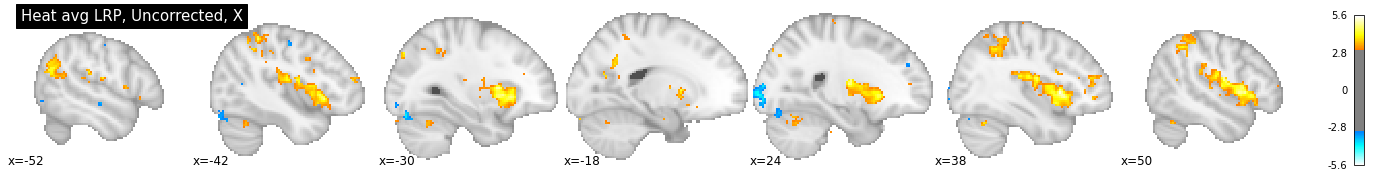

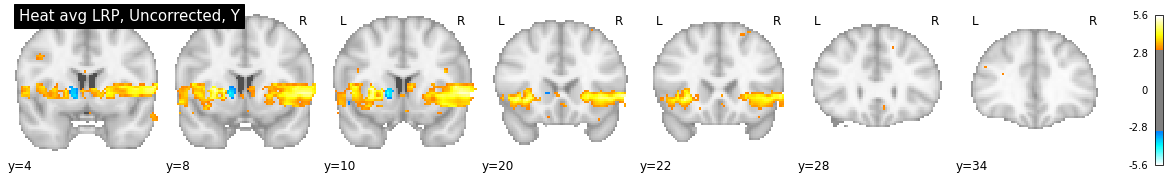

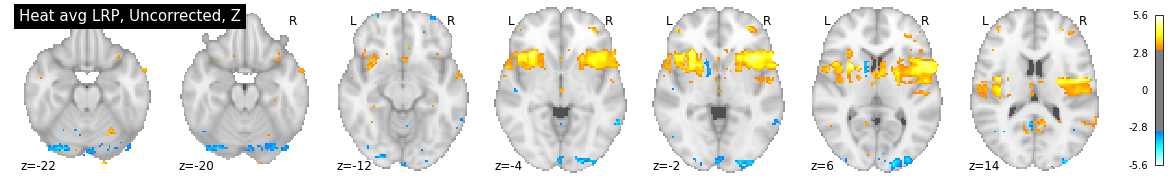

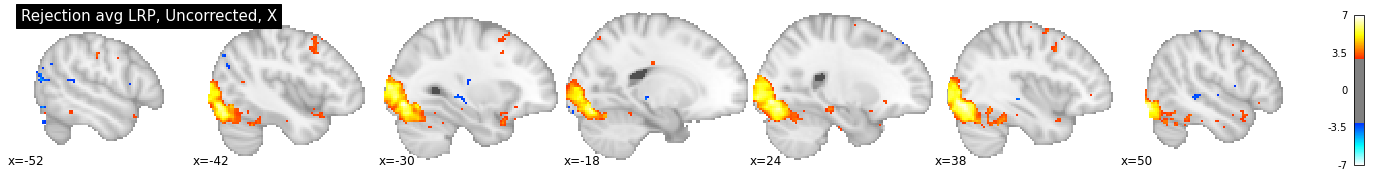

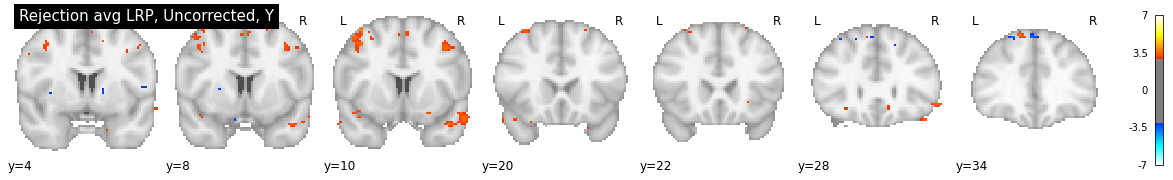

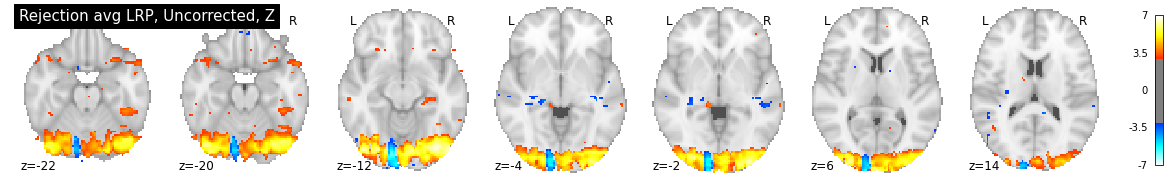

In [37]:
#Plotting uncorrected one-sample t-test
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, Uncorrected, X')
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, Uncorrected, Y')
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, Uncorrected, Z')

plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, Uncorrected, X')
plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, Uncorrected, Y')
plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, Uncorrected, Z')

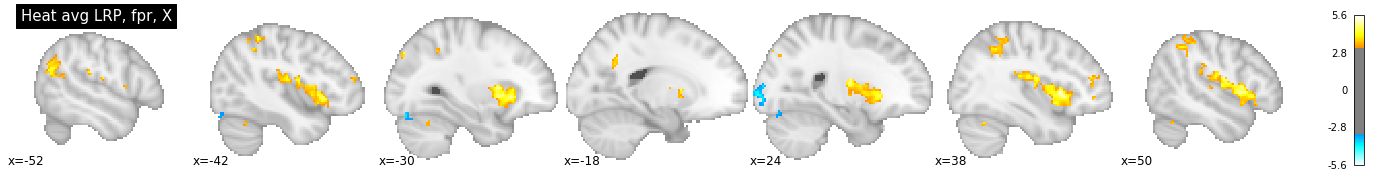

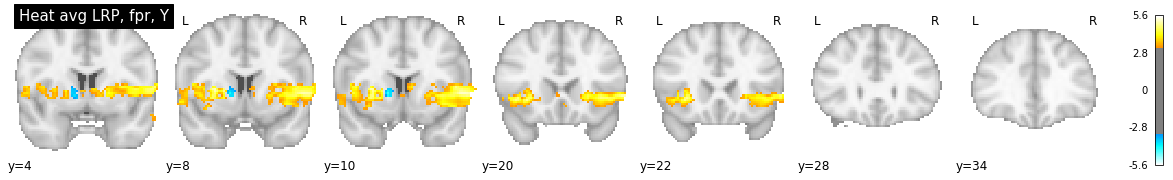

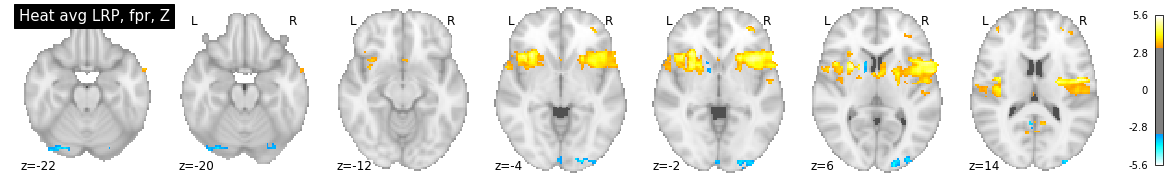

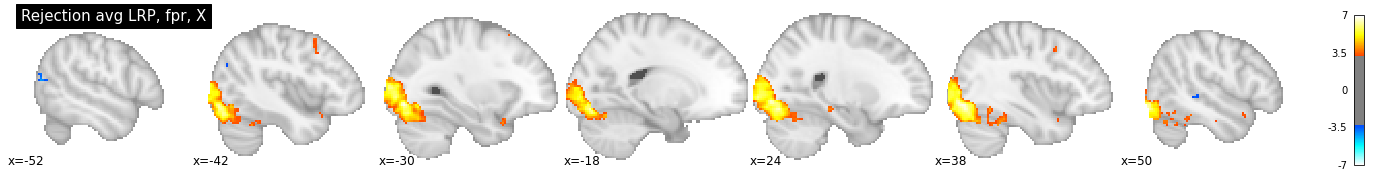

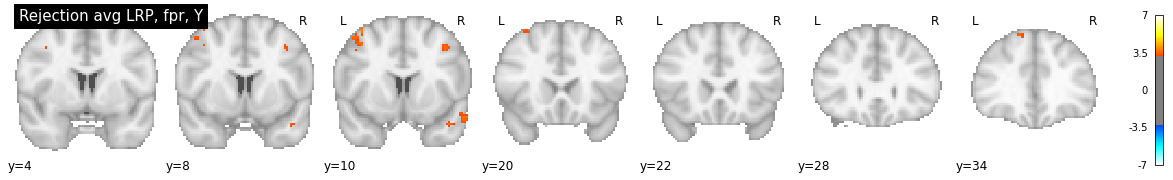

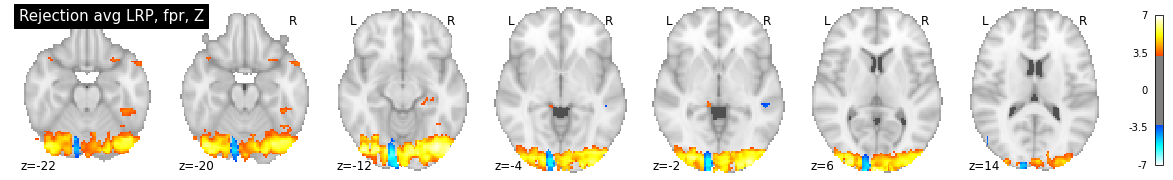

In [38]:
#Plotting corrected one-sample t-test(fpr)
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, fpr, X')
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, fpr, Y')
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, fpr, Z')

plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, fpr, X')
plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, fpr, Y')
plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, fpr, Z')

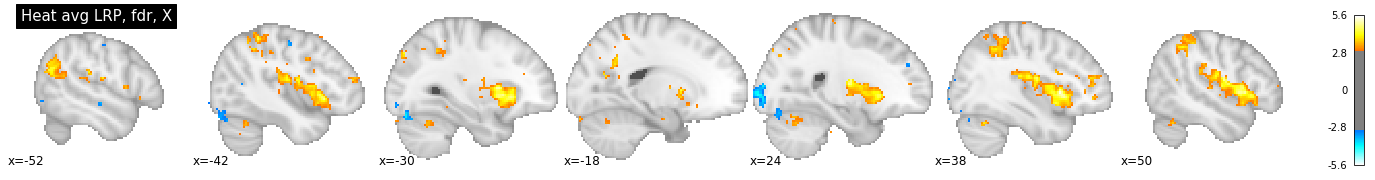

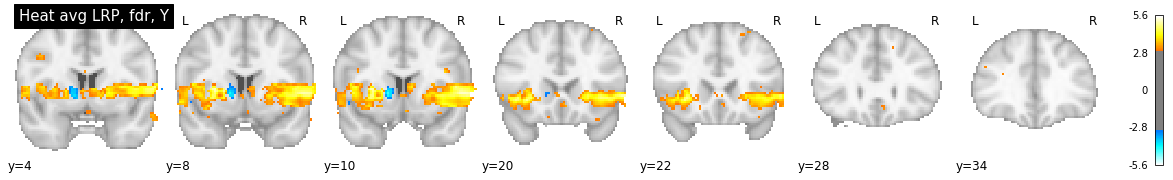

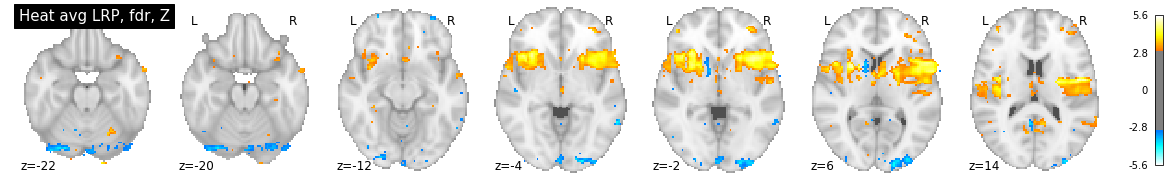

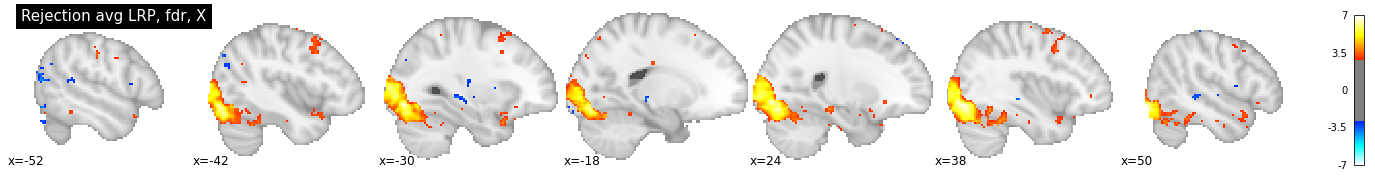

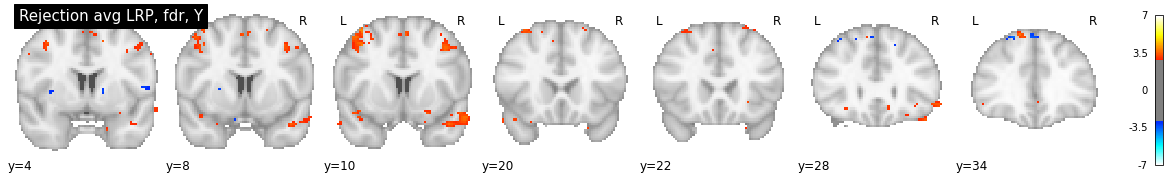

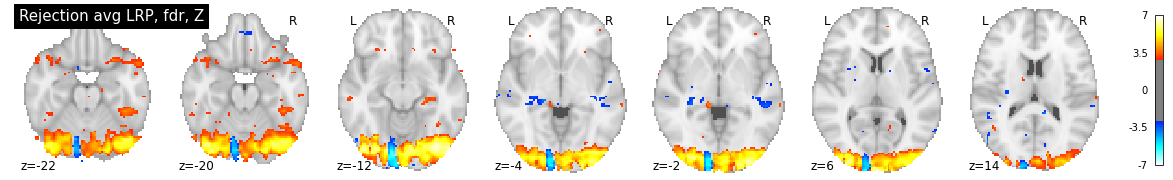

In [39]:
#Plotting corrected one-sample t-test(fdr)
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, fdr, X')
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, fdr, Y')
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, fdr, Z')

plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, fdr, X')
plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, fdr, Y')
plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, fdr, Z')

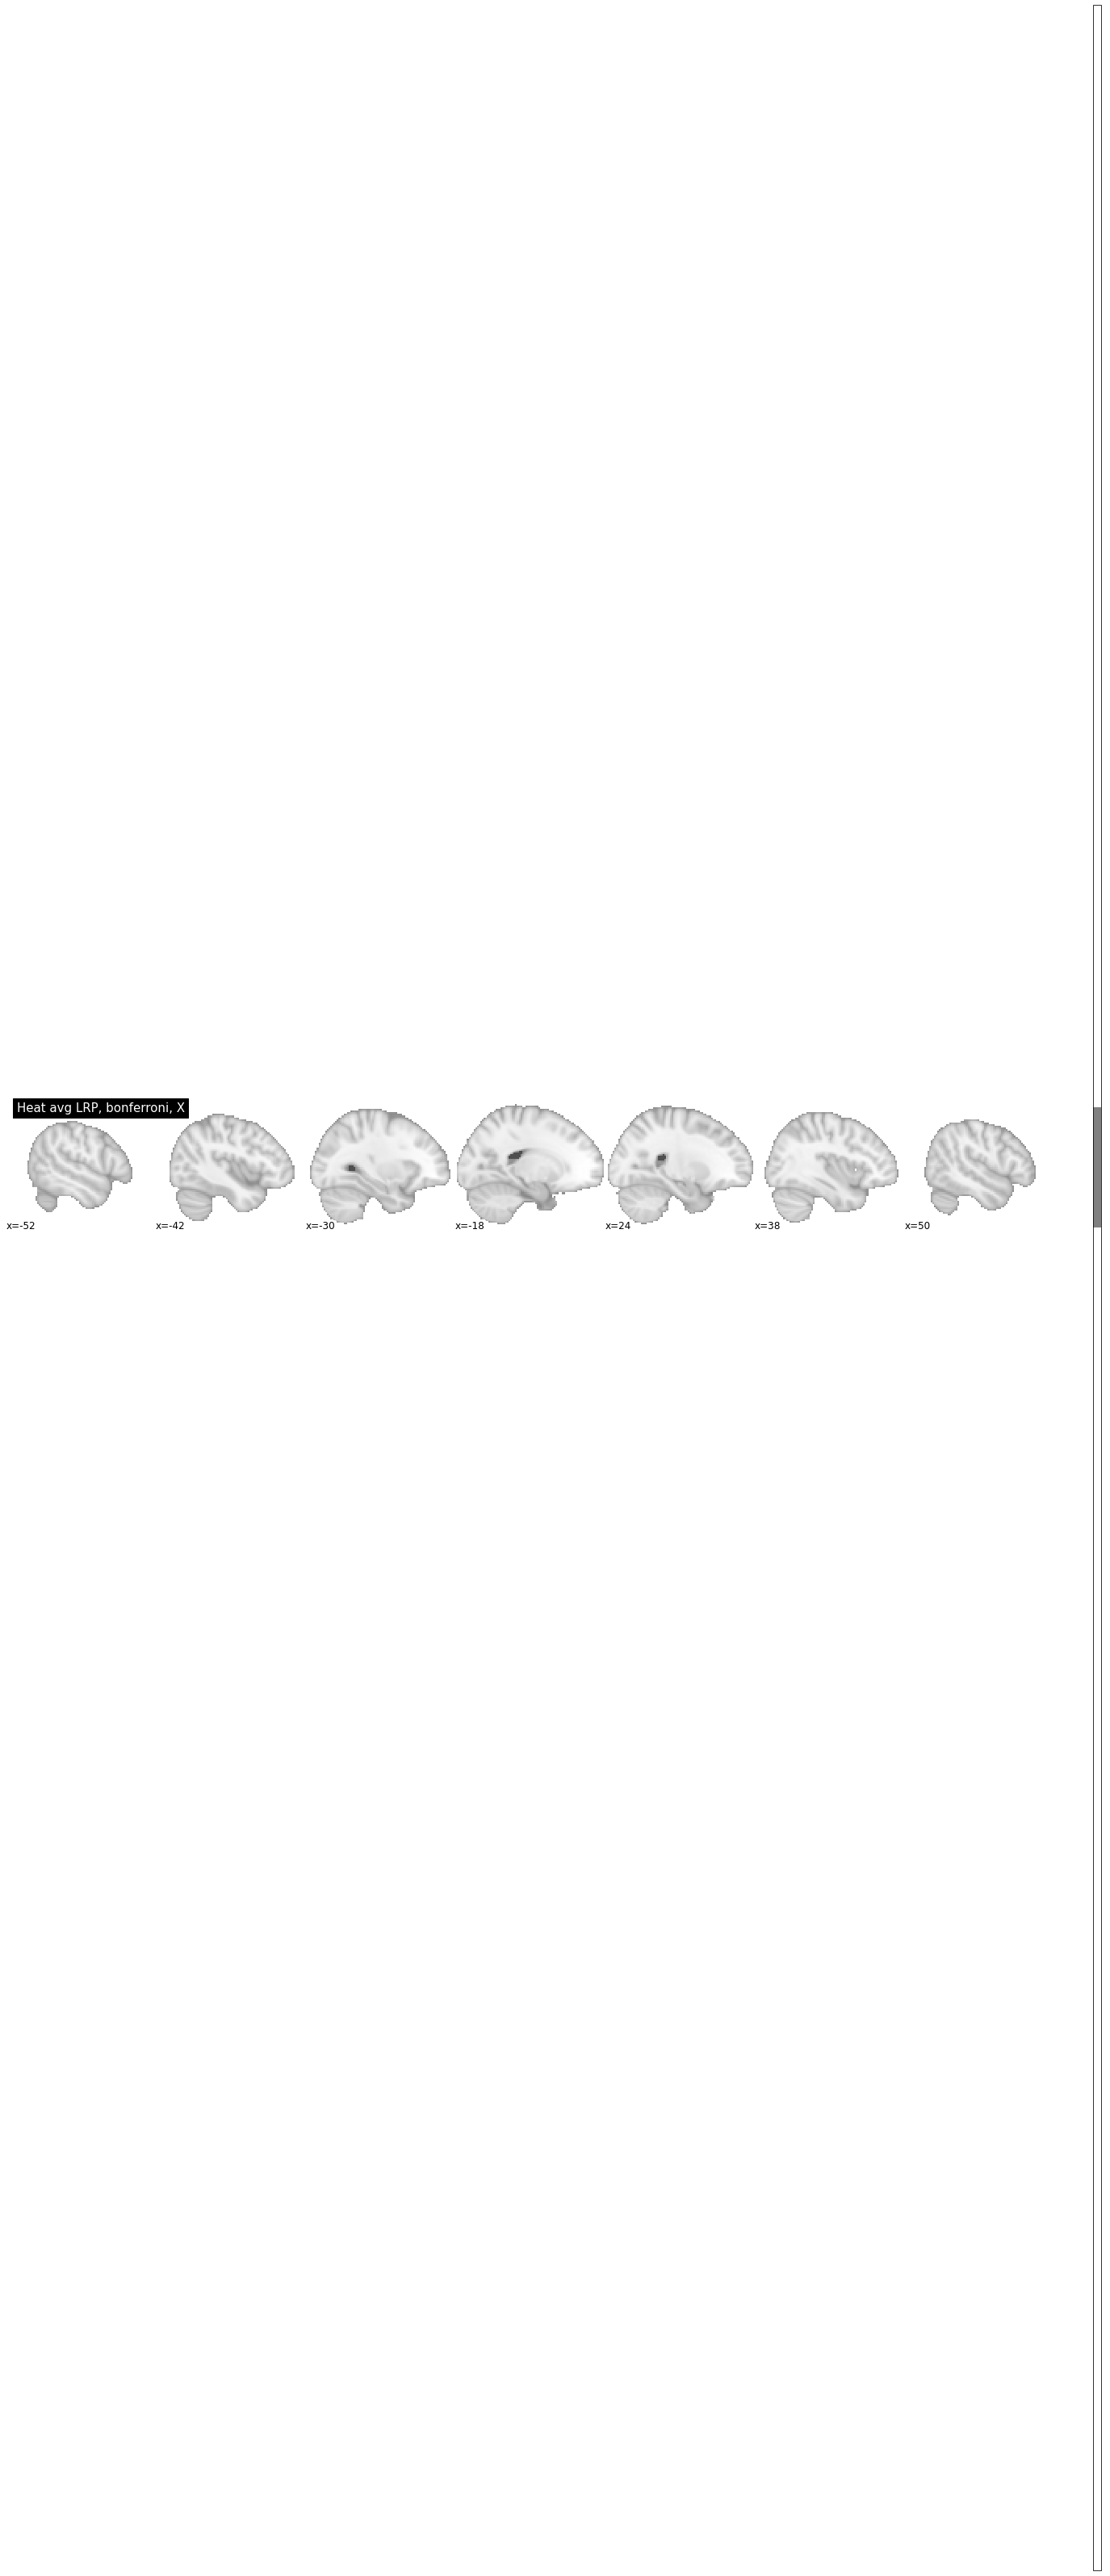

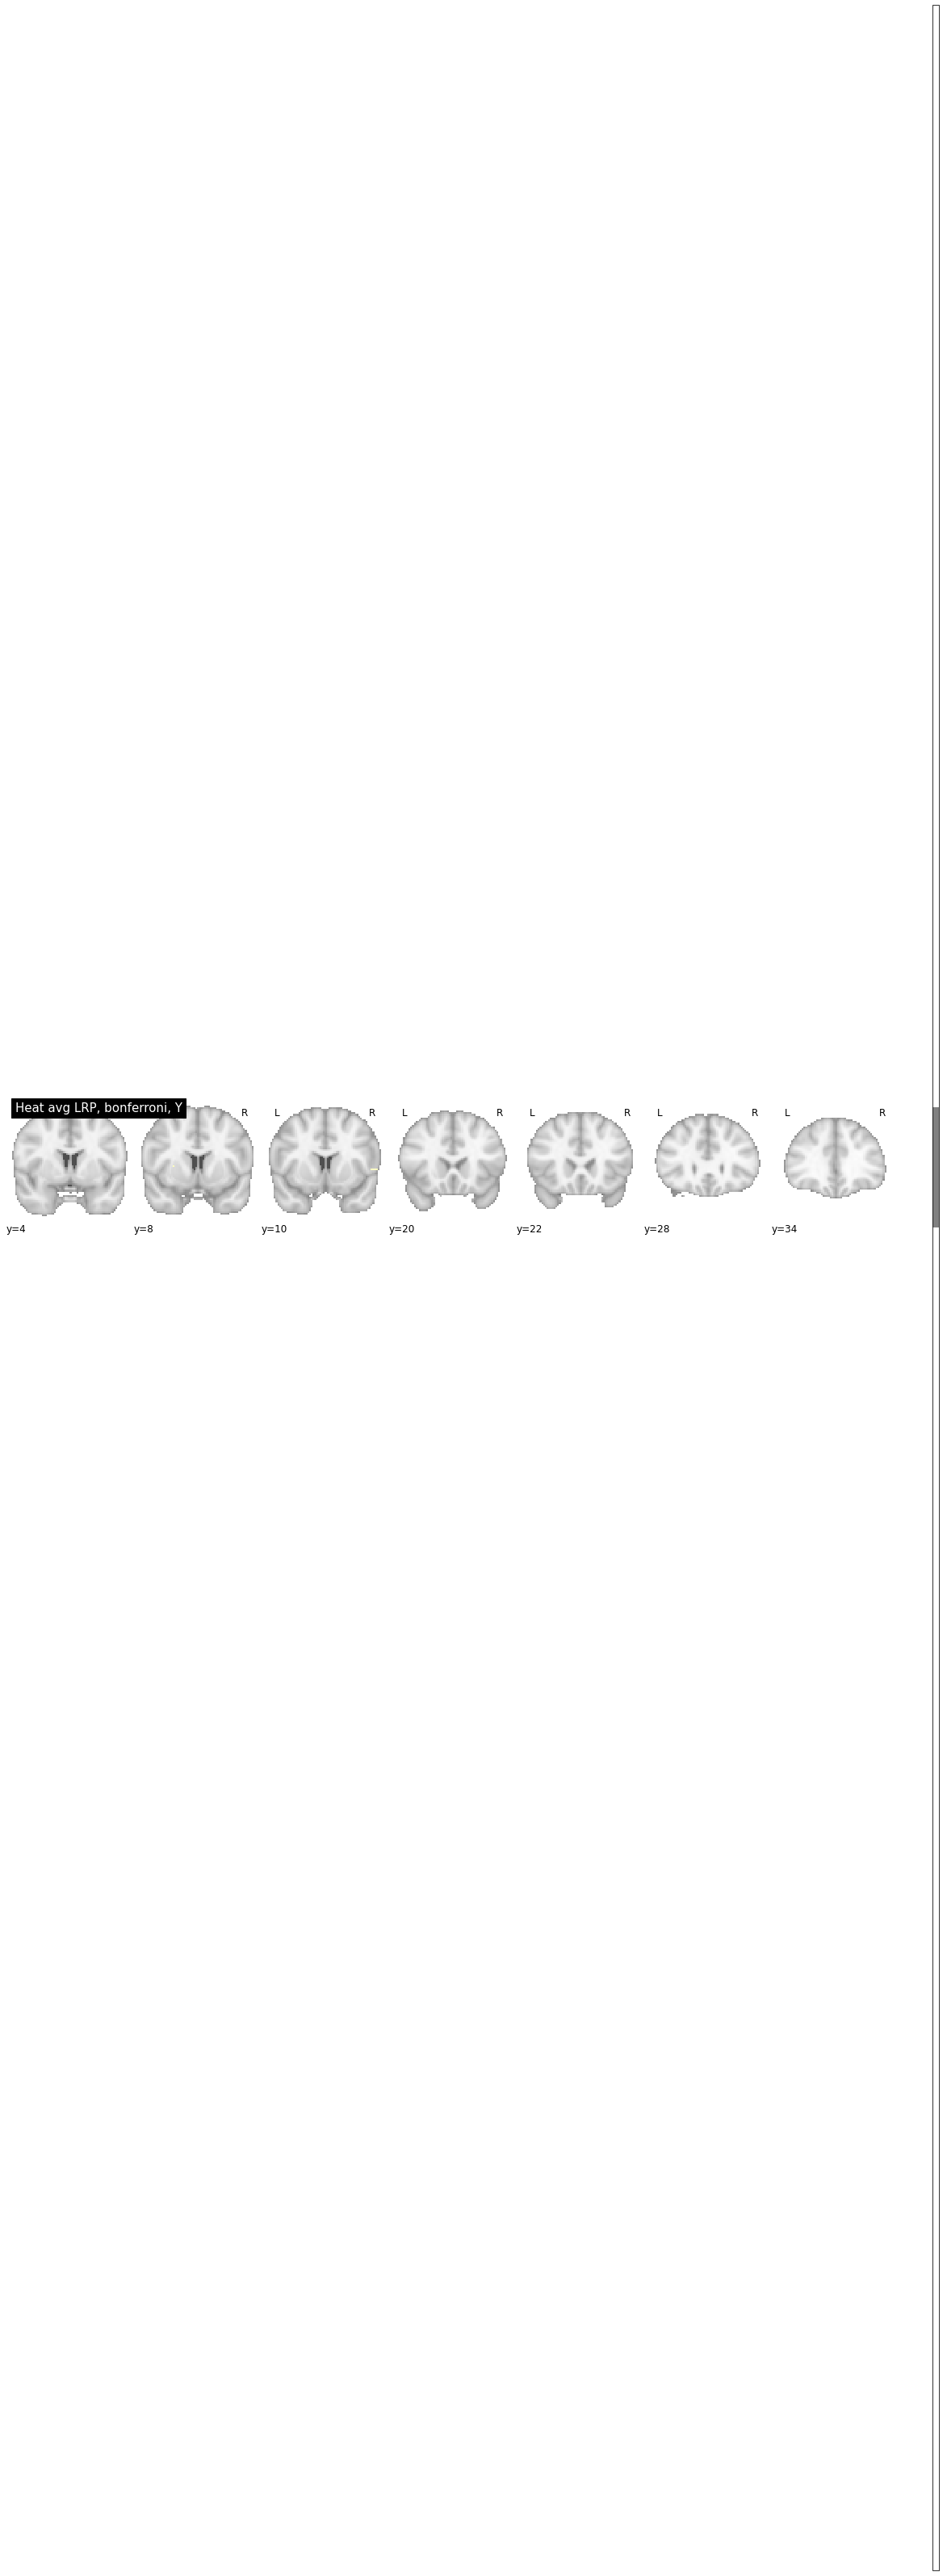

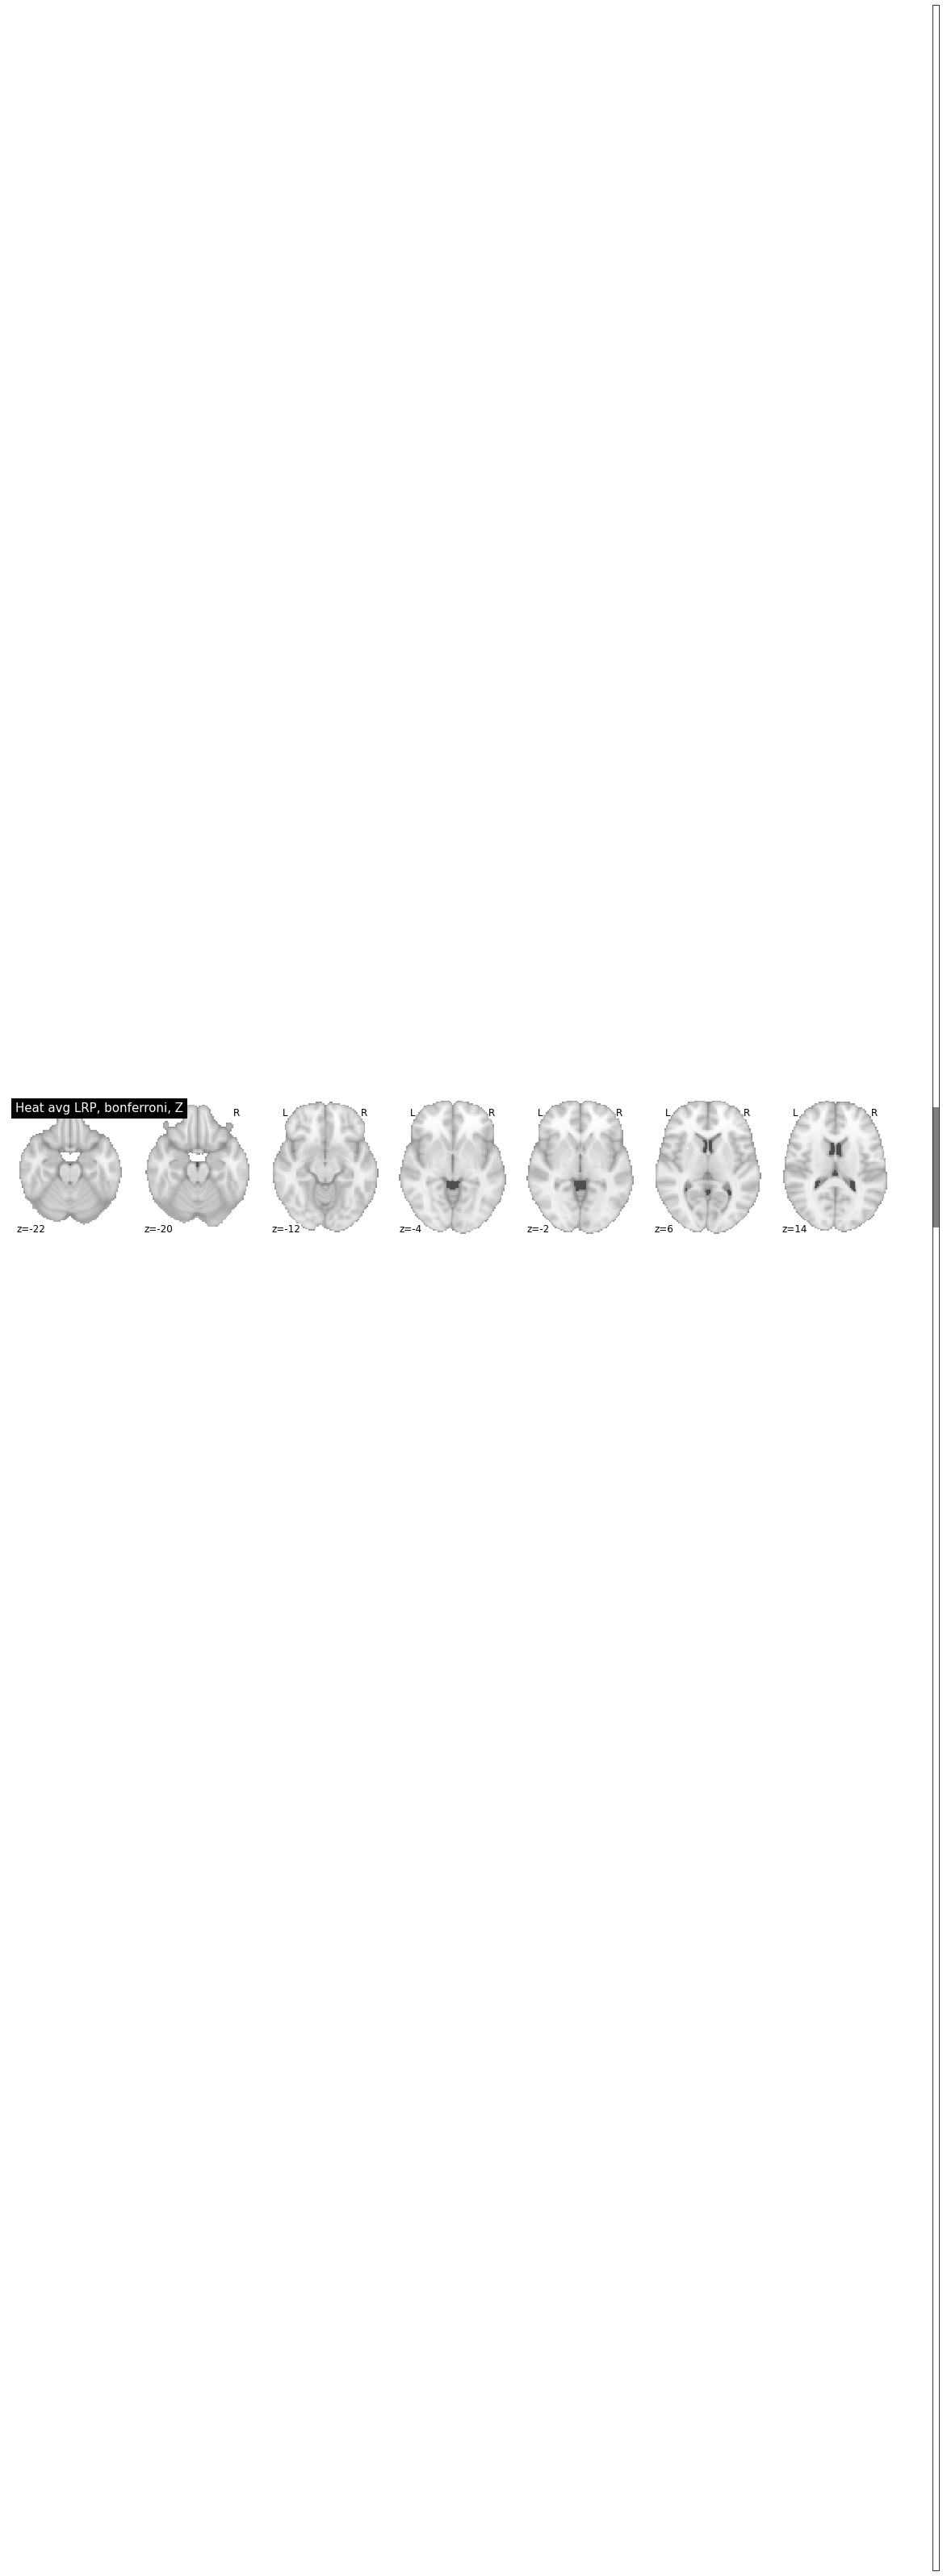

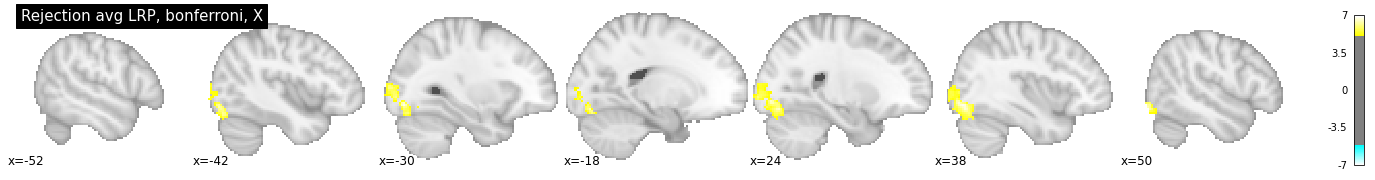

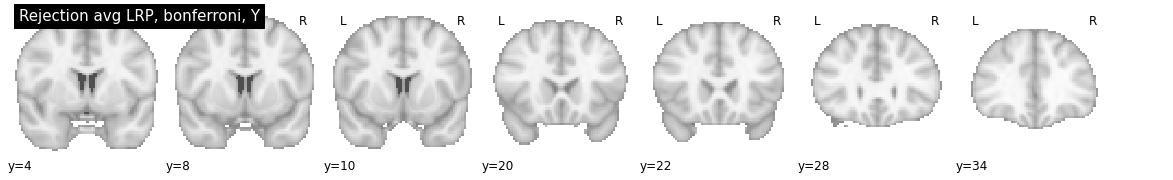

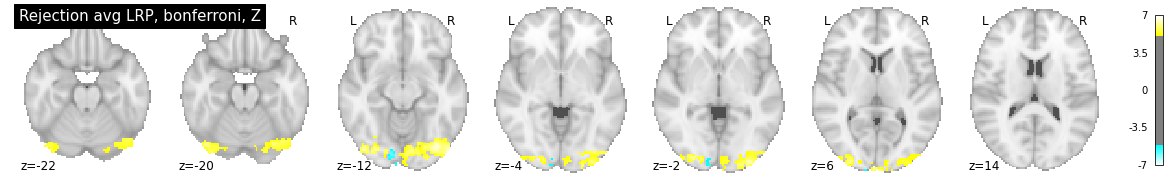

In [40]:
#Plotting corrected one-sample t-test(bonferroni)
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, bonferroni, X')
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, bonferroni, Y')
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, bonferroni, Z')

plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, bonferroni, X')
plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, bonferroni, Y')
plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, bonferroni, Z')

In [41]:
from nilearn import datasets, surface

#plotting surface stat map of uncorrected one-sample t-test
fsaverage = datasets.fetch_surf_fsaverage()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 0.74.

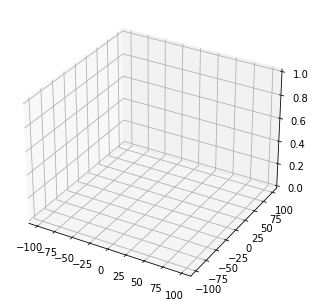

In [43]:
heat_right = surface.vol_to_surf(heat_avg_lrp_zmap, fsaverage.pial_right)
heat_left = surface.vol_to_surf(heat_avg_lrp_zmap, fsaverage.pial_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, heat_right, hemi='right',
                            title='Surface right hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, heat_left, hemi='left',
                            title='Surface left hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_left)
plotting.show()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 0.74.

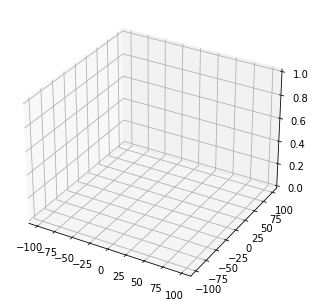

In [44]:
rej_right = surface.vol_to_surf(rej_avg_lrp_zmap, fsaverage.pial_right)
rej_left = surface.vol_to_surf(rej_avg_lrp_zmap, fsaverage.pial_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, rej_right, hemi='right',
                            title='Surface right hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, rej_left, hemi='left',
                            title='Surface left hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_left)
plotting.show()

If you get `NotImplementedError: It is not currently possible to manually set the aspect on 3D axes` error when you execute above cells, this is matplotlib version problem.

In order to solve this problem, please reinstall matplotlib 3.0.2 version and restart your jupyter notebook kernel.

In [ ]:
# If you want to reinstall matplotlib, execute the following codes.

# !pip uninstall -y matplotlib
# !pip install matplotlib==3.0.2

If you restart kernel, all variables are dissapear.
But you don't have to run all the cells again for visualization.

Just run those two cells

```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image
import nipype.interfaces.io as nio
import os

import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from keras.models import load_model



Bad key savefig.frameon in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Binary-Infantry\AppData\Roaming\Python\Python36\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filen

In [4]:
datapath = 'D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/data/derivatives/trial_images'
result_path = 'D:/academic/CAS.APM&HUST.fMRI/code/interpret_ml_neuroimaging-master/interpret_ml_neuroimaging-master/results/cnn_lrp'
dataframe_filename = 'cnn_lrp_dataframe.csv'


In [ ]:
and cells for **part8 visualization**.